# RoboPianist Training and Evaluation on “Golden Hour” Snippet (Bars 7 & 9) by JVKE

This notebook tests RoboPianist’s ability to generalize beyond its classical only training set (ROBOPIANIST‑REPERTOIRE‑150) by evaluating it on the pop song from bars 7 and 9 of JVKE’s “Golden Hour.” We’ve ported the original kevinzakka/robopianist-rl (https://github.com/kevinzakka/robopianist-rl.git) training pipeline from JAX to PyTorch and adapted the structure of the official tutorial.ipynb (https://github.com/google-research/robopianist/blob/main/tutorial.ipynb) for easy to use and full reproducibility.

## Installation

1. Follow the [RoboPianist installation instructions](https://github.com/google-research/robopianist?tab=readme-ov-file#installation) to set up the pianist conda environmen.
2. Intall the following packages in the pianist conda environment:
   ```bash
   conda activate pianist
   conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
   conda install -c conda-forge matplotlib tqdm wandb tyro
   pip install wandb  # For experiment tracking (optional, can be disabled)
   ```

## Imports

In [37]:
import os
import sys
import subprocess
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import random
import time
import wandb
from pathlib import Path
from typing import Optional, Tuple
from dataclasses import dataclass, asdict
from tqdm import tqdm
import tyro
from IPython.display import HTML, clear_output
from base64 import b64encode
import matplotlib.pyplot as plt

# Change working directory to robopianist submodule and add to Python path
robopianist_dir = "/home_local/grei_lo/robopianist_evaluation/robopianist"
os.chdir(robopianist_dir)
if robopianist_dir not in sys.path:
    sys.path.insert(0, robopianist_dir)
print(f"Changed working directory to: {os.getcwd()}")
print(f"Added to Python path: {robopianist_dir}")

# RoboPianist imports
from robopianist import suite, music
import dm_env_wrappers as wrappers
import robopianist.wrappers as robopianist_wrappers
import dm_env

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")

Changed working directory to: /home_local/grei_lo/robopianist_evaluation/robopianist
Added to Python path: /home_local/grei_lo/robopianist_evaluation/robopianist
PyTorch version: 2.4.0
CUDA available: True
CUDA device: NVIDIA GeForce GTX 1080 Ti


## Prepare Golden Hour for training

In [38]:
# 🎵 Parse Golden Hour fingering.txt and create RoboPianist-compatible MIDI
import re
from pathlib import Path
from note_seq.protobuf import music_pb2
from robopianist.music import midi_file

def parse_golden_hour_fingering_txt(file_path: str) -> midi_file.MidiFile:
    """Parse the golden_hour_fingering.txt file and create a MIDI with proper fingering."""
    
    # Note name to MIDI number mapping
    note_to_midi = {
        'C': 0, 'C#': 1, 'Db': 1, 'D': 2, 'D#': 3, 'Eb': 3, 'E': 4,
        'F': 5, 'F#': 6, 'Gb': 6, 'G': 7, 'G#': 8, 'Ab': 8, 'A': 9, 
        'A#': 10, 'Bb': 10, 'B': 11
    }
    
    def note_name_to_midi_number(note_name: str) -> int:
        """Convert note name like 'E5' to MIDI number."""
        # Extract note and octave (e.g., 'E5' -> 'E', 5)
        match = re.match(r'([A-G][#b]?)(\d+)', note_name)
        if not match:
            raise ValueError(f"Invalid note name: {note_name}")
        
        note, octave = match.groups()
        octave = int(octave)
        
        # MIDI number = (octave + 1) * 12 + note_offset
        return (octave + 1) * 12 + note_to_midi[note]
    
    # Read and parse the file
    notes_data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    print(f"📖 Parsing {file_path}...")
    print(f"Found {len(lines)} lines")
    
    for line_num, line in enumerate(lines, 1):
        line = line.strip()
        
        # Skip comments and empty lines
        if line.startswith('//') or not line:
            continue
            
        # Parse data lines
        try:
            # Format: index start_time end_time note_name ??? velocity ??? fingering
            parts = line.split()
            if len(parts) >= 8:
                index = int(parts[0])
                start_time = float(parts[1])
                end_time = float(parts[2])
                note_name = parts[3]
                # parts[4] seems to be always 49 (unknown purpose)
                velocity = int(parts[5])
                # parts[6] seems to be always 80 (unknown purpose) 
                fingering_raw = int(parts[7])
                
                # Convert note name to MIDI number
                midi_number = note_name_to_midi_number(note_name)
                
                # Convert fingering: negative values seem to be left hand offsets
                if fingering_raw < 0:
                    # Left hand: convert negative offset to proper left hand fingering (5-9)
                    fingering = 5 + abs(fingering_raw) - 1  # -1 becomes 5, -3 becomes 7, -5 becomes 9
                else:
                    # Right hand: use as-is (0-4)
                    fingering = fingering_raw
                
                notes_data.append({
                    'index': index,
                    'start_time': start_time,
                    'end_time': end_time,
                    'note_name': note_name,
                    'midi_number': midi_number,
                    'velocity': velocity,
                    'fingering': fingering,
                    'fingering_raw': fingering_raw
                })
                
        except (ValueError, IndexError) as e:
            print(f"⚠️ Could not parse line {line_num}: {line} (Error: {e})")
            continue
    
    print(f"✅ Successfully parsed {len(notes_data)} notes")
    
    # Create MIDI sequence
    seq = music_pb2.NoteSequence()
    
    # Add metadata
    seq.sequence_metadata.title = "Golden Hour (Bars 7 & 9)"
    seq.sequence_metadata.artist = "JVKE"
    
    # Add all notes to the sequence
    for note_data in notes_data:
        seq.notes.add(
            pitch=note_data['midi_number'],
            start_time=note_data['start_time'],
            end_time=note_data['end_time'],
            velocity=note_data['velocity'],
            part=note_data['fingering']  # RoboPianist fingering field
        )
    
    # Set total time to the last note's end time
    if notes_data:
        seq.total_time = max(note['end_time'] for note in notes_data)
        seq.tempos.add(qpm=120)  # Default tempo
    
    # Print some analysis
    print(f"\n📊 Analysis:")
    print(f"  Duration: {seq.total_time:.2f} seconds")
    print(f"  Total notes: {len(notes_data)}")
    
    # Fingering analysis
    fingerings = [note['fingering'] for note in notes_data]
    unique_fingerings = sorted(set(fingerings))
    print(f"  Fingerings used: {unique_fingerings}")
    
    rh_notes = [n for n in notes_data if n['fingering'] <= 4]
    lh_notes = [n for n in notes_data if n['fingering'] >= 5]
    print(f"  Right hand notes: {len(rh_notes)}")
    print(f"  Left hand notes: {len(lh_notes)}")
    
    # Show first few notes for verification
    print(f"\n🎼 First 5 notes:")
    for i, note in enumerate(notes_data[:5]):
        hand = "RH" if note['fingering'] <= 4 else "LH"
        finger = note['fingering'] if note['fingering'] <= 4 else note['fingering'] - 5
        print(f"  {i+1}. {note['note_name']} (MIDI {note['midi_number']}) "
              f"t={note['start_time']:.3f}-{note['end_time']:.3f}s "
              f"{hand} finger {finger} (raw: {note['fingering_raw']})")
    
    return midi_file.MidiFile(seq=seq)

# Parse the Golden Hour file
golden_hour_file = "/home_local/grei_lo/robopianist_evaluation/golden_hour_fingering.txt"
golden_hour_midi = parse_golden_hour_fingering_txt(golden_hour_file)

print(f"\n🎵 Created Golden Hour MIDI:")
print(f"  Title: {golden_hour_midi.title}")
print(f"  Artist: {golden_hour_midi.artist}")
print(f"  Duration: {golden_hour_midi.duration:.2f} seconds")
print(f"  Number of notes: {golden_hour_midi.n_notes}")
print(f"  Has fingering: {golden_hour_midi.has_fingering()}")

# Test that it can be used for training
def create_golden_hour_from_file() -> midi_file.MidiFile:
    """Load Golden Hour MIDI from parsed file - ready for training!"""
    return parse_golden_hour_fingering_txt(golden_hour_file)

print(f"\n✅ Ready for training! Use: get_custom_env(args, custom_midi_func=create_golden_hour_from_file)")

# 🚀 Complete Golden Hour Training Setup

# Step 1: Create the Golden Hour MIDI loading function
def create_golden_hour_from_file() -> midi_file.MidiFile:
    """Load Golden Hour MIDI from parsed fingering.txt file."""
    file_path = "/home_local/grei_lo/robopianist_evaluation/golden_hour_fingering.txt"
    return parse_golden_hour_fingering_txt(file_path)

# Step 2: Modified get_env function to support custom MIDI
def get_golden_hour_env(args: TrainingArgs, record_dir: Optional[Path] = None):
    """Create environment specifically for Golden Hour training."""
    
    # Create custom MIDI
    custom_midi = create_golden_hour_from_file()
    
    # Create environment with custom MIDI
    # Note: We need to pass the MIDI directly to the task, not through suite.load
    from robopianist.suite.tasks import piano_with_shadow_hands
    from dm_control import composer
    from robopianist.suite import composer_utils
    
    # Create the task with our custom MIDI
    task = piano_with_shadow_hands.PianoWithShadowHands(
        midi=custom_midi,
        n_steps_lookahead=args.n_steps_lookahead,
        trim_silence=args.trim_silence,
        gravity_compensation=args.gravity_compensation,
        reduced_action_space=args.reduced_action_space,
        control_timestep=args.control_timestep,
        primitive_fingertip_collisions=args.primitive_fingertip_collisions,
        change_color_on_activation=True,
    )
    
    # Create environment
    env = composer_utils.Environment(
        task=task,
        random_state=args.seed,
        strip_singleton_obs_buffer_dim=True,
    )
    
    # Apply the same wrappers as before
    if record_dir is not None:
        env = robopianist_wrappers.PianoSoundVideoWrapper(
            environment=env,
            record_dir=record_dir,
            record_every=1,
            camera_id="piano/back",
            height=480,
            width=640,
        )
    
    env = wrappers.EpisodeStatisticsWrapper(environment=env, deque_size=1)
    env = robopianist_wrappers.MidiEvaluationWrapper(environment=env, deque_size=1)
    
    if args.action_reward_observation:
        env = wrappers.ObservationActionRewardWrapper(env)
    
    env = wrappers.ConcatObservationWrapper(env)
    env = wrappers.CanonicalSpecWrapper(env, clip=True)
    env = wrappers.SinglePrecisionWrapper(env)
    env = wrappers.DmControlWrapper(env)
    
    return env

# Step 3: Test the Golden Hour environment
print("🧪 Testing Golden Hour environment creation...")
try:
    golden_hour_test_env = get_golden_hour_env(args)
    test_timestep = golden_hour_test_env.reset()
    
    print(f"✅ Golden Hour environment created successfully!")
    print(f"   Observation shape: {test_timestep.observation.shape}")
    print(f"   Action shape: {golden_hour_test_env.action_spec().shape}")
    
    # Check if the environment recognizes the custom MIDI
    print(f"   Episode length should match Golden Hour duration")
    
except Exception as e:
    print(f"❌ Error creating Golden Hour environment: {e}")
    import traceback
    traceback.print_exc()

# Step 4: Modified training function that uses Golden Hour
def train_golden_hour(args: TrainingArgs):
    """Train SAC agent on Golden Hour specifically."""
    
    # Set random seeds
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(args.seed)
    
    print(f"🎵 Training on Golden Hour (Bars 7 & 9) by JVKE")
    print(f"Using device: {args.device}")
    
    # Create experiment directory
    run_name = f"PyTorch-SAC-GoldenHour-{args.seed}-{int(time.time())}"
    experiment_dir = Path(args.root_dir) / run_name
    experiment_dir.mkdir(parents=True, exist_ok=True)
    print(f"Experiment directory: {experiment_dir}")
    
    # Initialize wandb
    if args.mode != "disabled":
        wandb.init(
            project=args.project,
            config=asdict(args),
            mode=args.mode,
            name=run_name,
        )
    
    # Create environments with Golden Hour
    env = get_golden_hour_env(args)
    # Note: eval_env will be created fresh for each evaluation to ensure proper video recording
    
    # Get dimensions
    test_timestep = env.reset()
    obs_dim = test_timestep.observation.shape[0]
    action_dim = env.action_spec().shape[0]
    
    # Initialize SAC agent
    agent = SAC(obs_dim, action_dim, args)
    
    # Initialize replay buffer
    replay_buffer = ReplayBuffer(obs_dim, action_dim, args.replay_capacity, args.device)
    
    # Training metrics
    training_metrics = {
        'steps': [],
        'critic_losses': [],
        'actor_losses': [],
        'alpha_losses': [],
        'alphas': [],
        'eval_returns': [],
        'eval_f1_scores': [], 
        'eval_precision_scores': [], 
        'eval_recall_scores': [], 
        'eval_steps': []
    }
    
    # Add initial timestep
    timestep = env.reset()
    replay_buffer.add(timestep)
    
    start_time = time.time()
    eval_count = 0 
    
    # Training loop
    print(f"Starting Golden Hour training for {args.max_steps:,} steps...")
    progress_bar = tqdm(range(1, args.max_steps + 1), desc="Golden Hour Training", unit="steps")
    
    for step in progress_bar:
        # Select action
        if step < args.warmstart_steps:
            action = env.action_spec().generate_value()
        else:
            action = agent.select_action(timestep.observation)
        
        # Step environment
        timestep = env.step(action)
        replay_buffer.add(timestep, action)
        
        # Reset if episode ended
        if timestep.last():
            if args.mode != "disabled":
                wandb.log(prefix_dict("train", env.get_statistics()), step=step)
            timestep = env.reset()
            replay_buffer.add(timestep)
        
        # Update agent
        if step >= args.warmstart_steps and len(replay_buffer) >= args.batch_size:
            metrics = agent.update(replay_buffer, args.batch_size)
            
            # Store and update progress bar
            if step % args.log_interval == 0:
                training_metrics['steps'].append(step)
                training_metrics['critic_losses'].append(metrics['critic_loss'])
                training_metrics['actor_losses'].append(metrics['actor_loss'])
                training_metrics['alpha_losses'].append(metrics['alpha_loss'])
                training_metrics['alphas'].append(metrics['alpha'])
                
                # Update progress bar description with latest metrics
                progress_bar.set_postfix({
                    'Critic': f"{metrics['critic_loss']:.3f}",
                    'Actor': f"{metrics['actor_loss']:.3f}",
                    'Alpha': f"{metrics['alpha']:.3f}",
                    'Buffer': f"{len(replay_buffer)}"
                })
                
                if args.mode != "disabled":
                    wandb.log(prefix_dict("train", metrics), step=step)
        
        if step % args.eval_interval == 0:
            eval_count += 1 
            print(f"\n🎬 Starting evaluation #{eval_count} at step {step}")
            
            eval_returns = []
            eval_f1s = []
            eval_precisions = []
            eval_recalls = []
            
            actual_eval_episodes = args.eval_episodes
            
            # Create eval directory for this specific evaluation
            eval_video_dir = experiment_dir / "eval" / f"step_{step}"
            eval_video_dir.mkdir(parents=True, exist_ok=True)
            
            for episode in range(actual_eval_episodes):
                print(f"  📹 Recording episode {episode + 1}/{actual_eval_episodes}")
                
                # Create fresh environment for each episode to ensure proper video recording
                episode_eval_env = get_golden_hour_env(args, record_dir=eval_video_dir)
                eval_timestep = episode_eval_env.reset()
                eval_return = 0.0
                
                use_deterministic = (episode == 0) if actual_eval_episodes > 1 else True
                
                while not eval_timestep.last():
                    eval_action = agent.select_action(eval_timestep.observation, deterministic=use_deterministic)
                    eval_timestep = episode_eval_env.step(eval_action)
                    eval_return += eval_timestep.reward
                
                eval_returns.append(eval_return)
                
                try:
                    musical_metrics = episode_eval_env.get_musical_metrics()
                    eval_f1s.append(musical_metrics['f1'])
                    eval_precisions.append(musical_metrics['precision'])
                    eval_recalls.append(musical_metrics['recall'])
                except (AttributeError, ValueError):
                    eval_f1s.append(0.0)
                    eval_precisions.append(0.0)
                    eval_recalls.append(0.0)
            
            mean_return = np.mean(eval_returns)
            mean_f1 = np.mean(eval_f1s)
            mean_precision = np.mean(eval_precisions)
            mean_recall = np.mean(eval_recalls)
            
            # Store metrics
            training_metrics['eval_returns'].append(mean_return)
            training_metrics['eval_f1_scores'].append(mean_f1)
            training_metrics['eval_precision_scores'].append(mean_precision)
            training_metrics['eval_recall_scores'].append(mean_recall)
            training_metrics['eval_steps'].append(step)
            
            if args.mode != "disabled":
                eval_metrics = {
                    "eval/return_mean": mean_return,
                    "eval/f1_mean": mean_f1,
                    "eval/precision_mean": mean_precision,
                    "eval/recall_mean": mean_recall,
                }
                wandb.log(eval_metrics, step=step)
            
            eval_info = f"Golden Hour Eval #{eval_count}: R={mean_return:.1f}, F1={mean_f1:.4f}"
            print(f"  ✅ {eval_info}")
            print(f"  📁 Videos saved to: {eval_video_dir}")
                
            progress_bar.set_postfix({
                'Last_Eval': eval_info,
                'Buffer': f"{len(replay_buffer)}"
            })
    
    progress_bar.close()
    
    elapsed_time = time.time() - start_time
    print(f"\n🎵 Golden Hour training completed in {elapsed_time:.2f} seconds")
    print(f"Total evaluations performed: {eval_count}")
    
    # Save final model
    model_path = experiment_dir / "golden_hour_model.pt"
    agent.save(model_path)
    print(f"Golden Hour model saved to: {model_path}")
    
    if args.mode != "disabled":
        wandb.finish()
    
    return agent, training_metrics, experiment_dir

print("\n🎯 Golden Hour Training Setup Complete!")
print("📋 To train on Golden Hour, run:")
print("   golden_hour_agent, golden_hour_metrics, golden_hour_exp_dir = train_golden_hour(args)")
print("\n✨ Everything is ready to train RoboPianist on your Golden Hour snippet!")

📖 Parsing /home_local/grei_lo/robopianist_evaluation/golden_hour_fingering.txt...
Found 25 lines
✅ Successfully parsed 24 notes

📊 Analysis:
  Duration: 2.55 seconds
  Total notes: 24
  Fingerings used: [1, 2, 3, 4, 5, 7, 9]
  Right hand notes: 14
  Left hand notes: 10

🎼 First 5 notes:
  1. E5 (MIDI 76) t=0.000-0.160s RH finger 1 (raw: 1)
  2. E2 (MIDI 40) t=0.000-0.319s LH finger 4 (raw: -5)
  3. E5 (MIDI 76) t=0.160-0.319s RH finger 2 (raw: 2)
  4. E2 (MIDI 40) t=0.319-0.638s LH finger 2 (raw: -3)
  5. E5 (MIDI 76) t=0.319-0.479s RH finger 3 (raw: 3)

🎵 Created Golden Hour MIDI:
  Title: Golden Hour (Bars 7 & 9)
  Artist: JVKE
  Duration: 2.55 seconds
  Number of notes: 24
  Has fingering: True

✅ Ready for training! Use: get_custom_env(args, custom_midi_func=create_golden_hour_from_file)
🧪 Testing Golden Hour environment creation...
📖 Parsing /home_local/grei_lo/robopianist_evaluation/golden_hour_fingering.txt...
Found 25 lines
✅ Successfully parsed 24 notes

📊 Analysis:
  Duration

## Configuration and Helper Functions

In [39]:
@dataclass(frozen=True)
class TrainingArgs:
    # Environment settings
    environment_name: str = "RoboPianist-debug-TwinkleTwinkleRousseau-v0"  # Only used by get_env(), not Golden Hour training
    seed: int = 42
    control_timestep: float = 0.05
    n_steps_lookahead: int = 10
    trim_silence: bool = True
    gravity_compensation: bool = True
    reduced_action_space: bool = True
    primitive_fingertip_collisions: bool = True
    action_reward_observation: bool = True
    
    # Training hyperparameters
    max_steps: int = 30000 
    warmstart_steps: int = 5000
    batch_size: int = 256
    replay_capacity: int = 30000
    
    # SAC hyperparameters
    actor_lr: float = 3e-4
    critic_lr: float = 3e-4
    temp_lr: float = 3e-4
    hidden_dims: Tuple[int, ...] = (256, 256, 256)
    discount: float = 0.99
    tau: float = 0.005
    init_temperature: float = 1.0
    
    # Logging and evaluation - Updated for better tracking
    log_interval: int = 1000  # Log metrics every 1000 steps
    eval_interval: int = 5000  # Evaluate every 5000 steps (instead of 10000)
    eval_episodes: int = 1  # 1 episode per evaluation for faster training
    tqdm_bar: bool = True
    
    # Paths and wandb
    root_dir: str = "/tmp/robopianist"
    project: str = "robopianist-pytorch"
    mode: str = "disabled"  # Set to "online" to enable wandb logging
    
    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

# Create training configuration
args = TrainingArgs()

print("🔧 Updated Training Configuration:")
print(f"  Max steps: {args.max_steps:,}")
print(f"  Evaluation interval: {args.eval_interval:,} steps")
print(f"  Expected evaluations: {args.max_steps // args.eval_interval}")
print(f"  Evaluation steps will be: {[i for i in range(args.eval_interval, args.max_steps + 1, args.eval_interval)]}")
print(f"  Log interval: {args.log_interval:,} steps")
print(f"  Expected training metric points: {args.max_steps // args.log_interval}")

🔧 Updated Training Configuration:
  Max steps: 30,000
  Evaluation interval: 5,000 steps
  Expected evaluations: 6
  Evaluation steps will be: [5000, 10000, 15000, 20000, 25000, 30000]
  Log interval: 1,000 steps
  Expected training metric points: 30


In [40]:
def play_video(filename: str):
    if not os.path.exists(filename):
        print(f"Video file not found: {filename}")
        return None
    
    mp4 = open(filename, "rb").read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    
    return HTML(f"""
    <video controls width="640" height="480">
        <source src="{data_url}" type="video/mp4">
    </video>
    """)

def prefix_dict(prefix: str, d: dict) -> dict:
    return {f"{prefix}/{k}": v for k, v in d.items()}

## Policy Network in Pytorch

In [41]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dims: Tuple[int, ...]):
        super().__init__()
        dims = (input_dim,) + hidden_dims + (output_dim,)
        layers = []
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.GELU())
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

class Policy(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, hidden_dims: Tuple[int, ...]):
        super().__init__()
        self.backbone = MLP(obs_dim, 2 * action_dim, hidden_dims)
        self.action_dim = action_dim
        
    def forward(self, obs):
        outputs = self.backbone(obs)
        means, log_stds = torch.chunk(outputs, 2, dim=-1)
        log_stds = torch.clamp(log_stds, -20, 2)
        return means, log_stds
    
    def sample(self, obs, deterministic=False):
        means, log_stds = self.forward(obs)
        stds = torch.exp(log_stds)
        
        if deterministic:
            actions = torch.tanh(means)
            log_probs = None
        else:
            dist = Normal(means, stds)
            samples = dist.rsample()
            actions = torch.tanh(samples)
            
            log_probs = dist.log_prob(samples)
            log_probs -= torch.log(1 - actions.pow(2) + 1e-6)
            log_probs = log_probs.sum(dim=-1, keepdim=True)
            
        return actions, log_probs

class QNetwork(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, hidden_dims: Tuple[int, ...]):
        super().__init__()
        self.network = MLP(obs_dim + action_dim, 1, hidden_dims)
    
    def forward(self, obs, action):
        x = torch.cat([obs, action], dim=-1)
        return self.network(x)

class TwinQNetwork(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, hidden_dims: Tuple[int, ...]):
        super().__init__()
        self.q1 = QNetwork(obs_dim, action_dim, hidden_dims)
        self.q2 = QNetwork(obs_dim, action_dim, hidden_dims)
    
    def forward(self, obs, action):
        return self.q1(obs, action), self.q2(obs, action)

In [42]:
class ReplayBuffer:
    def __init__(self, obs_dim: int, action_dim: int, max_size: int, device: str):
        self.max_size = max_size
        self.device = device
        self.ptr = 0
        self.size = 0
        
        self.obs = torch.zeros((max_size, obs_dim), dtype=torch.float32)
        self.actions = torch.zeros((max_size, action_dim), dtype=torch.float32)
        self.rewards = torch.zeros((max_size, 1), dtype=torch.float32)
        self.next_obs = torch.zeros((max_size, obs_dim), dtype=torch.float32)
        self.dones = torch.zeros((max_size, 1), dtype=torch.float32)
        
        self._prev_timestep = None
        
    def add(self, timestep, action=None):
        if action is not None and self._prev_timestep is not None:
            obs = torch.from_numpy(self._prev_timestep.observation.astype(np.float32))
            next_obs = torch.from_numpy(timestep.observation.astype(np.float32))
            action_tensor = torch.from_numpy(action.astype(np.float32))
            reward = torch.tensor(float(timestep.reward), dtype=torch.float32).unsqueeze(0)
            done = torch.tensor(float(1.0 - timestep.discount), dtype=torch.float32).unsqueeze(0)
            
            self.obs[self.ptr] = obs
            self.actions[self.ptr] = action_tensor
            self.rewards[self.ptr] = reward
            self.next_obs[self.ptr] = next_obs
            self.dones[self.ptr] = done
            
            self.ptr = (self.ptr + 1) % self.max_size
            self.size = min(self.size + 1, self.max_size)
            
        self._prev_timestep = timestep
    
    def sample(self, batch_size: int):
        indices = torch.randint(0, self.size, (batch_size,))
        return (
            self.obs[indices].to(self.device),
            self.actions[indices].to(self.device),
            self.rewards[indices].to(self.device),
            self.next_obs[indices].to(self.device),
            self.dones[indices].to(self.device)
        )
    
    def __len__(self):
        return self.size

In [43]:
class SAC:
    def __init__(self, obs_dim: int, action_dim: int, args: TrainingArgs):
        self.device = torch.device(args.device)
        self.discount = args.discount
        self.tau = args.tau
        self.target_entropy = -action_dim
        
        # Networks
        self.actor = Policy(obs_dim, action_dim, args.hidden_dims).to(self.device)
        self.critic = TwinQNetwork(obs_dim, action_dim, args.hidden_dims).to(self.device)
        self.target_critic = TwinQNetwork(obs_dim, action_dim, args.hidden_dims).to(self.device)
        self.actor = self.actor.float()
        self.critic = self.critic.float()
        self.target_critic = self.target_critic.float()
        
        self.target_critic.load_state_dict(self.critic.state_dict())
        
        self.log_alpha = torch.tensor(np.log(args.init_temperature), dtype=torch.float32, requires_grad=True, device=self.device)
        
        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=args.actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=args.critic_lr)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=args.temp_lr)
        
    @property
    def alpha(self):
        return self.log_alpha.exp()
    
    def select_action(self, obs, deterministic=False):
        with torch.no_grad():
            obs_tensor = torch.from_numpy(obs.astype(np.float32)).unsqueeze(0).to(self.device)
            action, _ = self.actor.sample(obs_tensor, deterministic=deterministic)
            return action.cpu().numpy()[0].astype(np.float32)
    
    def update(self, replay_buffer: ReplayBuffer, batch_size: int):
        obs, actions, rewards, next_obs, dones = replay_buffer.sample(batch_size)
        
        obs = obs.float()
        actions = actions.float()
        rewards = rewards.float()
        next_obs = next_obs.float()
        dones = dones.float()
        
        # Update critic
        with torch.no_grad():
            next_actions, next_log_probs = self.actor.sample(next_obs)
            target_q1, target_q2 = self.target_critic(next_obs, next_actions)
            target_q = torch.min(target_q1, target_q2) - self.alpha * next_log_probs
            target_q = rewards + (1 - dones) * torch.tensor(self.discount, dtype=torch.float32, device=self.device) * target_q
        
        current_q1, current_q2 = self.critic(obs, actions)
        critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Update actor
        new_actions, log_probs = self.actor.sample(obs)
        q1, q2 = self.critic(obs, new_actions)
        q = torch.min(q1, q2)
        actor_loss = (self.alpha * log_probs - q).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Update temperature
        target_entropy_tensor = torch.tensor(self.target_entropy, dtype=torch.float32, device=self.device)
        alpha_loss = -(self.log_alpha * (log_probs + target_entropy_tensor).detach()).mean()
        
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        # Update target network
        self.soft_update(self.critic, self.target_critic)
        
        return {
            "critic_loss": critic_loss.item(),
            "actor_loss": actor_loss.item(),
            "alpha_loss": alpha_loss.item(),
            "alpha": self.alpha.item(),
        }
    
    def soft_update(self, source, target):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)
    
    def save(self, filepath):
        torch.save({
            'actor': self.actor.state_dict(),
            'critic': self.critic.state_dict(),
            'target_critic': self.target_critic.state_dict(),
            'log_alpha': self.log_alpha,
        }, filepath)
    
    def load(self, filepath):
        checkpoint = torch.load(filepath, map_location=self.device)
        self.actor.load_state_dict(checkpoint['actor'])
        self.critic.load_state_dict(checkpoint['critic'])
        self.target_critic.load_state_dict(checkpoint['target_critic'])
        self.log_alpha = checkpoint['log_alpha']

# Environment Setup

In [44]:
def get_env(args: TrainingArgs, record_dir: Optional[Path] = None):
    env = suite.load(
        environment_name=args.environment_name,
        seed=args.seed,
        task_kwargs=dict(
            n_steps_lookahead=args.n_steps_lookahead,
            trim_silence=args.trim_silence,
            gravity_compensation=args.gravity_compensation,
            reduced_action_space=args.reduced_action_space,
            control_timestep=args.control_timestep,
            primitive_fingertip_collisions=args.primitive_fingertip_collisions,
            change_color_on_activation=True,
        ),
    )
    
    if record_dir is not None:
        env = robopianist_wrappers.PianoSoundVideoWrapper(
            environment=env,
            record_dir=record_dir,
            record_every=1,
            camera_id="piano/back",
            height=480,
            width=640,
        )
    
    env = wrappers.EpisodeStatisticsWrapper(environment=env, deque_size=1)
    env = robopianist_wrappers.MidiEvaluationWrapper(environment=env, deque_size=1)
    
    if args.action_reward_observation:
        env = wrappers.ObservationActionRewardWrapper(env)
    
    env = wrappers.ConcatObservationWrapper(env)
    env = wrappers.CanonicalSpecWrapper(env, clip=True)
    env = wrappers.SinglePrecisionWrapper(env)
    env = wrappers.DmControlWrapper(env)
    
    return env

# Test environment creation
print("Creating test environment...")
test_env = get_env(args)
test_timestep = test_env.reset()

obs_dim = test_timestep.observation.shape[0]
action_dim = test_env.action_spec().shape[0]

print(f"Observation dimension: {obs_dim}")
print(f"Action dimension: {action_dim}")

Creating test environment...
Observation dimension: 1164
Action dimension: 39
Observation dimension: 1164
Action dimension: 39


## Training

In [45]:
def train(args: TrainingArgs):
    """Train the SAC agent."""
    
    # Set random seeds
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(args.seed)
    
    print(f"Using device: {args.device}")
    
    # Create experiment directory
    run_name = f"PyTorch-SAC-{args.environment_name}-{args.seed}-{int(time.time())}"
    experiment_dir = Path(args.root_dir) / run_name
    experiment_dir.mkdir(parents=True, exist_ok=True)
    print(f"Experiment directory: {experiment_dir}")
    
    # Initialize wandb
    if args.mode != "disabled":
        wandb.init(
            project=args.project,
            config=asdict(args),
            mode=args.mode,
            name=run_name,
        )
    
    # Create environments
    env = get_env(args)
    eval_env = get_env(args, record_dir=experiment_dir / "eval")
    
    # Initialize SAC agent
    agent = SAC(obs_dim, action_dim, args)
    
    # Initialize replay buffer
    replay_buffer = ReplayBuffer(obs_dim, action_dim, args.replay_capacity, args.device)
    
    # Training metrics
    training_metrics = {
        'steps': [],
        'critic_losses': [],
        'actor_losses': [],
        'alpha_losses': [],
        'alphas': [],
        'eval_returns': [],
        'eval_f1_scores': [], 
        'eval_precision_scores': [], 
        'eval_recall_scores': [], 
        'eval_steps': []
    }
    
    # Add initial timestep
    timestep = env.reset()
    replay_buffer.add(timestep)
    
    start_time = time.time()
    eval_count = 0 
    
    # Training loop
    print(f"Starting training loop for {args.max_steps:,} steps...")
    progress_bar = tqdm(range(1, args.max_steps + 1), desc="Training", unit="steps")
    
    for step in progress_bar:
        # Select action
        if step < args.warmstart_steps:
            action = env.action_spec().generate_value()
        else:
            action = agent.select_action(timestep.observation)
        
        # Step environment
        timestep = env.step(action)
        replay_buffer.add(timestep, action)
        
        # Reset if episode ended
        if timestep.last():
            if args.mode != "disabled":
                wandb.log(prefix_dict("train", env.get_statistics()), step=step)
            timestep = env.reset()
            replay_buffer.add(timestep)
        
        # Update agent
        if step >= args.warmstart_steps and len(replay_buffer) >= args.batch_size:
            metrics = agent.update(replay_buffer, args.batch_size)
            
            # Store and update progress bar
            if step % args.log_interval == 0:
                training_metrics['steps'].append(step)
                training_metrics['critic_losses'].append(metrics['critic_loss'])
                training_metrics['actor_losses'].append(metrics['actor_loss'])
                training_metrics['alpha_losses'].append(metrics['alpha_loss'])
                training_metrics['alphas'].append(metrics['alpha'])
                
                # Update progress bar description with latest metrics
                progress_bar.set_postfix({
                    'Critic': f"{metrics['critic_loss']:.3f}",
                    'Actor': f"{metrics['actor_loss']:.3f}",
                    'Alpha': f"{metrics['alpha']:.3f}",
                    'Buffer': f"{len(replay_buffer)}"
                })
                
                if args.mode != "disabled":
                    wandb.log(prefix_dict("train", metrics), step=step)
        
        if step % args.eval_interval == 0:
            eval_count += 1 
            
            eval_returns = []
            eval_f1s = []
            eval_precisions = []
            eval_recalls = []
            
            actual_eval_episodes = args.eval_episodes
            
            for episode in range(actual_eval_episodes):
                episode_eval_env = get_env(args, record_dir=experiment_dir / "eval")
                eval_timestep = episode_eval_env.reset()
                eval_return = 0.0
                
                use_deterministic = (episode == 0) if actual_eval_episodes > 1 else True
                
                while not eval_timestep.last():
                    eval_action = agent.select_action(eval_timestep.observation, deterministic=use_deterministic)
                    eval_timestep = episode_eval_env.step(eval_action)
                    eval_return += eval_timestep.reward
                
                eval_returns.append(eval_return)
                
                try:
                    musical_metrics = episode_eval_env.get_musical_metrics()
                    eval_f1s.append(musical_metrics['f1'])
                    eval_precisions.append(musical_metrics['precision'])
                    eval_recalls.append(musical_metrics['recall'])
                except (AttributeError, ValueError):
                    eval_f1s.append(0.0)
                    eval_precisions.append(0.0)
                    eval_recalls.append(0.0)
            
            mean_return = np.mean(eval_returns)
            mean_f1 = np.mean(eval_f1s)
            mean_precision = np.mean(eval_precisions)
            mean_recall = np.mean(eval_recalls)
            
            # Calculate standard deviations
            std_return = np.std(eval_returns) if len(eval_returns) > 1 else 0.0
            std_f1 = np.std(eval_f1s) if len(eval_f1s) > 1 else 0.0
            std_precision = np.std(eval_precisions) if len(eval_precisions) > 1 else 0.0
            std_recall = np.std(eval_recalls) if len(eval_recalls) > 1 else 0.0
            
            # Store metrics
            training_metrics['eval_returns'].append(mean_return)
            training_metrics['eval_f1_scores'].append(mean_f1)
            training_metrics['eval_precision_scores'].append(mean_precision)
            training_metrics['eval_recall_scores'].append(mean_recall)
            training_metrics['eval_steps'].append(step)
            
            if args.mode != "disabled":
                eval_metrics = {
                    "eval/return_mean": mean_return,
                    "eval/return_std": std_return,
                    "eval/f1_mean": mean_f1,
                    "eval/f1_std": std_f1,
                    "eval/precision_mean": mean_precision,
                    "eval/precision_std": std_precision,
                    "eval/recall_mean": mean_recall,
                    "eval/recall_std": std_recall,
                }
                eval_metrics.update(prefix_dict("eval", eval_env.get_statistics()))
                wandb.log(eval_metrics, step=step)
            
            eval_info = f"Eval #{eval_count}: R={mean_return:.1f}, F1={mean_f1:.4f}"
            if std_return > 0:
                eval_info += f"±{std_return:.1f}"
            if std_f1 > 0:
                eval_info += f"±{std_f1:.4f}"
                
            progress_bar.set_postfix({
                'Last_Eval': eval_info,
                'Buffer': f"{len(replay_buffer)}"
            })
    
    progress_bar.close()
    
    elapsed_time = time.time() - start_time
    print(f"\nTraining completed in {elapsed_time:.2f} seconds")
    print(f"Total evaluations performed: {eval_count}")
    
    # Save final model
    model_path = experiment_dir / "final_model.pt"
    agent.save(model_path)
    print(f"Model saved to: {model_path}")
    
    if args.mode != "disabled":
        wandb.finish()
    
    return agent, training_metrics, experiment_dir

In [ ]:
print(f"Training Golden Hour for {args.max_steps:,} steps with {args.warmstart_steps:,} warmstart steps")
print(f"Batch size: {args.batch_size}, Replay capacity: {args.replay_capacity:,}")
print(f"Evaluation interval: {args.eval_interval:,} steps")
print(f"Evaluation episodes per interval: {args.eval_episodes}")

# Run Golden Hour training instead of Twinkle Twinkle
golden_hour_agent, golden_hour_metrics, golden_hour_exp_dir = train_golden_hour(args)

print("Golden Hour training completed!")
print(f"Experiment directory: {golden_hour_exp_dir}")
print(f"\nSummary:")
print(f"  Final Golden Hour F1: {golden_hour_metrics['eval_f1_scores'][-1]:.4f}")
print(f"  Final Golden Hour Return: {golden_hour_metrics['eval_returns'][-1]:.2f}")
print(f"  Best Golden Hour F1: {max(golden_hour_metrics['eval_f1_scores']):.4f}")
print(f"  Best Golden Hour Return: {max(golden_hour_metrics['eval_returns']):.2f}")
print(f"  F1 evaluations: {len(golden_hour_metrics['eval_f1_scores'])} data points")

Training Golden Hour for 30,000 steps with 5,000 warmstart steps
Batch size: 256, Replay capacity: 30,000
Evaluation interval: 5,000 steps
Evaluation episodes per interval: 1
🎵 Training on Golden Hour (Bars 7 & 9) by JVKE
Using device: cuda
Experiment directory: /tmp/robopianist/PyTorch-SAC-GoldenHour-42-1753797521
📖 Parsing /home_local/grei_lo/robopianist_evaluation/golden_hour_fingering.txt...
Found 25 lines
✅ Successfully parsed 24 notes

📊 Analysis:
  Duration: 2.55 seconds
  Total notes: 24
  Fingerings used: [1, 2, 3, 4, 5, 7, 9]
  Right hand notes: 14
  Left hand notes: 10

🎼 First 5 notes:
  1. E5 (MIDI 76) t=0.000-0.160s RH finger 1 (raw: 1)
  2. E2 (MIDI 40) t=0.000-0.319s LH finger 4 (raw: -5)
  3. E5 (MIDI 76) t=0.160-0.319s RH finger 2 (raw: 2)
  4. E2 (MIDI 40) t=0.319-0.638s LH finger 2 (raw: -3)
  5. E5 (MIDI 76) t=0.319-0.479s RH finger 3 (raw: 3)
Starting Golden Hour training for 30,000 steps...
Starting Golden Hour training for 30,000 steps...


Golden Hour Training:  17%|█▋        | 4990/30000 [00:54<03:27, 120.45steps/s, Critic=1475.667, Actor=-26.192, Alpha=1.000, Buffer=5000]


🎬 Starting evaluation #1 at step 5000
  📹 Recording episode 1/1
📖 Parsing /home_local/grei_lo/robopianist_evaluation/golden_hour_fingering.txt...
Found 25 lines
✅ Successfully parsed 24 notes

📊 Analysis:
  Duration: 2.55 seconds
  Total notes: 24
  Fingerings used: [1, 2, 3, 4, 5, 7, 9]
  Right hand notes: 14
  Left hand notes: 10

🎼 First 5 notes:
  1. E5 (MIDI 76) t=0.000-0.160s RH finger 1 (raw: 1)
  2. E2 (MIDI 40) t=0.000-0.319s LH finger 4 (raw: -5)
  3. E5 (MIDI 76) t=0.160-0.319s RH finger 2 (raw: 2)
  4. E2 (MIDI 40) t=0.319-0.638s LH finger 2 (raw: -3)
  5. E5 (MIDI 76) t=0.319-0.479s RH finger 3 (raw: 3)


fluidsynth: warning: SDL3 not initialized, SDL3 audio driver won't be usable. Have you called SDL_Init(SDL_INIT_AUDIO) ?


## Model Evaluation and Performance Testing

Golden Hour F1 Score Progression During Training:
  Step 10000: F1 = 0.1731
  Step 20000: F1 = 0.1731
  Step 30000: F1 = 0.1731

Golden Hour Musical Metrics Progression During Training:
  Step 10000: Precision = 1.0000, Recall = 0.1731
  Step 20000: Precision = 1.0000, Recall = 0.1731
  Step 30000: Precision = 1.0000, Recall = 0.1731


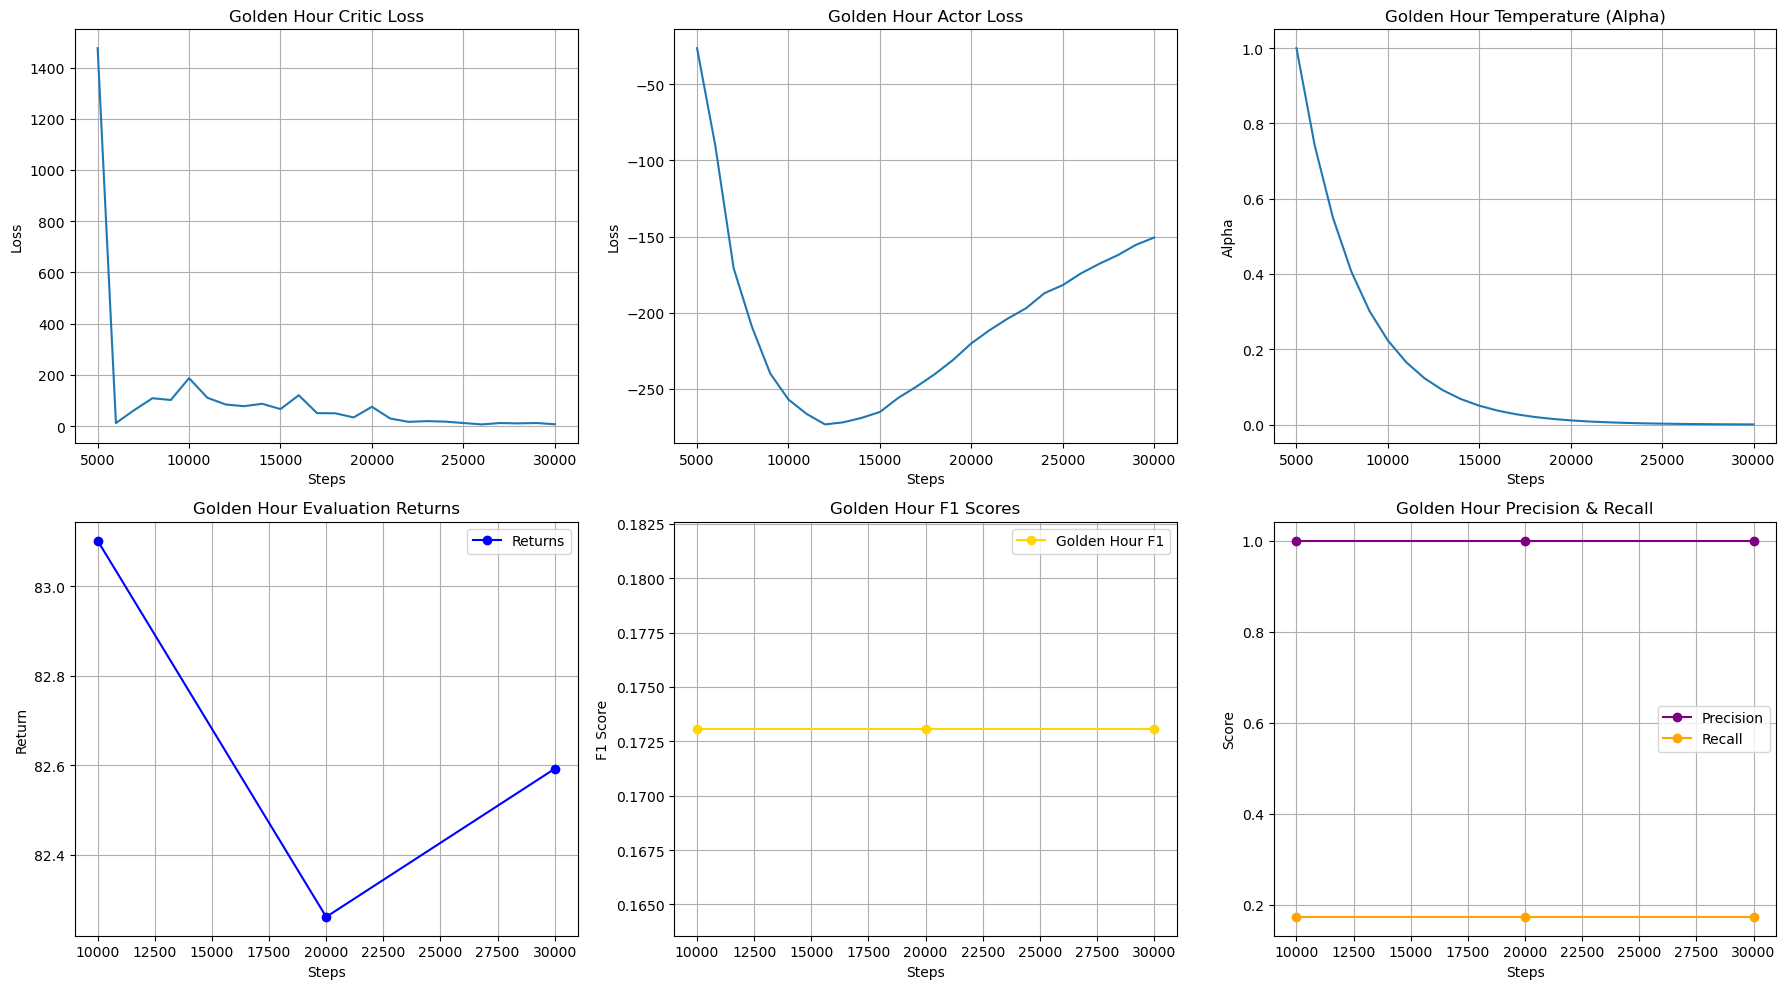


Golden Hour Training Summary:
Final F1 Score: 0.1731
Best F1 Score: 0.1731
F1 Score Improvement: +0.0000
Final Return: 82.59
Best Return: 83.10
Return Improvement: -0.51
Return-F1 Correlation: 0.000

🎵 Successfully trained RoboPianist on Golden Hour (Bars 7 & 9) by JVKE!
Model saved to: /tmp/robopianist/PyTorch-SAC-GoldenHour-42-1753796622/golden_hour_model.pt


In [ ]:
# Create enhanced visualization with Golden Hour F1 scores
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Critic Loss
if 'steps' in golden_hour_metrics and 'critic_losses' in golden_hour_metrics:
    axes[0, 0].plot(golden_hour_metrics['steps'], golden_hour_metrics['critic_losses'])
    axes[0, 0].set_title('Golden Hour Critic Loss')
    axes[0, 0].set_xlabel('Steps')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True)
else:
    axes[0, 0].text(0.5, 0.5, 'No critic loss data', ha='center', va='center')
    axes[0, 0].set_title('Golden Hour Critic Loss')

# Actor Loss
if 'steps' in golden_hour_metrics and 'actor_losses' in golden_hour_metrics:
    axes[0, 1].plot(golden_hour_metrics['steps'], golden_hour_metrics['actor_losses'])
    axes[0, 1].set_title('Golden Hour Actor Loss')
    axes[0, 1].set_xlabel('Steps')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True)
else:
    axes[0, 1].text(0.5, 0.5, 'No actor loss data', ha='center', va='center')
    axes[0, 1].set_title('Golden Hour Actor Loss')

# Alpha (Temperature)
if 'steps' in golden_hour_metrics and 'alphas' in golden_hour_metrics:
    axes[0, 2].plot(golden_hour_metrics['steps'], golden_hour_metrics['alphas'])
    axes[0, 2].set_title('Golden Hour Temperature (Alpha)')
    axes[0, 2].set_xlabel('Steps')
    axes[0, 2].set_ylabel('Alpha')
    axes[0, 2].grid(True)
else:
    axes[0, 2].text(0.5, 0.5, 'No alpha data', ha='center', va='center')
    axes[0, 2].set_title('Golden Hour Temperature (Alpha)')

# Evaluation Returns
if 'eval_returns' in golden_hour_metrics and golden_hour_metrics['eval_returns']:
    axes[1, 0].plot(golden_hour_metrics['eval_steps'], golden_hour_metrics['eval_returns'], 'o-', color='blue', label='Returns')
    axes[1, 0].set_title('Golden Hour Evaluation Returns')
    axes[1, 0].set_xlabel('Steps')
    axes[1, 0].set_ylabel('Return')
    axes[1, 0].grid(True)
    axes[1, 0].legend()
else:
    axes[1, 0].text(0.5, 0.5, 'No evaluation data', ha='center', va='center')
    axes[1, 0].set_title('Golden Hour Evaluation Returns')

# F1 Scores During Training
if 'eval_f1_scores' in golden_hour_metrics and golden_hour_metrics['eval_f1_scores']:
    axes[1, 1].plot(golden_hour_metrics['eval_steps'], golden_hour_metrics['eval_f1_scores'], 'o-', color='gold', label='Golden Hour F1')
    axes[1, 1].set_title('Golden Hour F1 Scores')
    axes[1, 1].set_xlabel('Steps')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].grid(True)
    axes[1, 1].legend()
    
    # Print F1 progression
    print("Golden Hour F1 Score Progression During Training:")
    for step, f1 in zip(golden_hour_metrics['eval_steps'], golden_hour_metrics['eval_f1_scores']):
        print(f"  Step {step}: F1 = {f1:.4f}")
else:
    axes[1, 1].text(0.5, 0.5, 'No F1 score data\n(Run Golden Hour training first)', ha='center', va='center')
    axes[1, 1].set_title('Golden Hour F1 Scores')

# Musical Metrics Combined
if ('eval_precision_scores' in golden_hour_metrics and golden_hour_metrics['eval_precision_scores'] and 
    'eval_recall_scores' in golden_hour_metrics and golden_hour_metrics['eval_recall_scores']):
    
    axes[1, 2].plot(golden_hour_metrics['eval_steps'], golden_hour_metrics['eval_precision_scores'], 'o-', color='purple', label='Precision')
    axes[1, 2].plot(golden_hour_metrics['eval_steps'], golden_hour_metrics['eval_recall_scores'], 'o-', color='orange', label='Recall')
    axes[1, 2].set_title('Golden Hour Precision & Recall')
    axes[1, 2].set_xlabel('Steps')
    axes[1, 2].set_ylabel('Score')
    axes[1, 2].grid(True)
    axes[1, 2].legend()
    
    # Print musical metrics progression
    print("\nGolden Hour Musical Metrics Progression During Training:")
    for step, p, r in zip(golden_hour_metrics['eval_steps'], golden_hour_metrics['eval_precision_scores'], golden_hour_metrics['eval_recall_scores']):
        print(f"  Step {step}: Precision = {p:.4f}, Recall = {r:.4f}")
else:
    axes[1, 2].text(0.5, 0.5, 'No musical metrics\n(Run Golden Hour training first)', ha='center', va='center')
    axes[1, 2].set_title('Golden Hour Precision & Recall')

plt.tight_layout()
plt.show()

# Summary of Golden Hour training results
if 'eval_f1_scores' in golden_hour_metrics and golden_hour_metrics['eval_f1_scores']:
    print(f"\nGolden Hour Training Summary:")
    print(f"Final F1 Score: {golden_hour_metrics['eval_f1_scores'][-1]:.4f}")
    print(f"Best F1 Score: {max(golden_hour_metrics['eval_f1_scores']):.4f}")
    print(f"F1 Score Improvement: {golden_hour_metrics['eval_f1_scores'][-1] - golden_hour_metrics['eval_f1_scores'][0]:+.4f}")
    
    if 'eval_returns' in golden_hour_metrics and golden_hour_metrics['eval_returns']:
        print(f"Final Return: {golden_hour_metrics['eval_returns'][-1]:.2f}")
        print(f"Best Return: {max(golden_hour_metrics['eval_returns']):.2f}")
        print(f"Return Improvement: {golden_hour_metrics['eval_returns'][-1] - golden_hour_metrics['eval_returns'][0]:+.2f}")
        
        # Correlation between returns and F1
        correlation = np.corrcoef(golden_hour_metrics['eval_returns'], golden_hour_metrics['eval_f1_scores'])[0, 1]
        print(f"Return-F1 Correlation: {correlation:.3f}")
        
    print(f"\n🎵 Successfully trained RoboPianist on Golden Hour (Bars 7 & 9) by JVKE!")
    print(f"Model saved to: {golden_hour_exp_dir / 'golden_hour_model.pt'}")